## dependencies

In [ ]:
!git clone https://github.com/mehardsingh/prefix-tuning.git

Cloning into 'prefix-tuning'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 87 (delta 43), reused 57 (delta 23), pack-reused 0
Receiving objects: 100% (87/87), 42.44 KiB | 1.63 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
%cd prefix-tuning

/content/prefix-tuning


In [ ]:
!pip install datasets
!pip install transformers
!pip install evaluate
# !pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 723.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl 

In [ ]:
from trainer_compatible.bert_prefix import BertForSequenceClassification_Prefix
from trainer_compatible.bert_prefix_gated import BertForSequenceClassification_Prefix_Gated
from trainer_compatible.roberta_prefix import RobertaForSequenceClassification_Prefix
from trainer_compatible.roberta_prefix_gated import RobertaForSequenceClassification_Prefix_Gated

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

input_ids torch.Size([2, 7])
logits torch.Size([2, 3])


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import random

## All

In [ ]:
dataset = load_dataset("ag_news")
train_ds = dataset["train"]
test_ds = dataset["test"]

In [ ]:
random_indices = random.sample(range(len(train_ds)), 30000)
train_ds = train_ds.select(random_indices)

random_indices = random.sample(range(len(test_ds)), 7500)
test_ds = test_ds.select(random_indices)

In [ ]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## BERT Architecture Models

In [ ]:
model_name = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def preprocess_function(sample):
    return tokenizer(sample["text"], truncation=True, max_length=256)

tokenized_train_ds = train_ds.map(preprocess_function, batched=True)
tokenized_test_ds = test_ds.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_ds['label']

### BERT

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = 4

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 109485316


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/bert",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.293900,0.220392,0.926800
2,0.156300,0.222627,0.931733
3,0.098400,0.247485,0.932533
4,0.065900,0.300772,0.928267
5,0.039100,0.358182,0.929467
6,0.023500,0.422059,0.931067
7,0.014900,0.461817,0.932133
8,0.009800,0.549135,0.927333
9,0.009600,0.575471,0.924267
10,0.008300,0.559672,0.932667


TrainOutput(global_step=18760, training_loss=0.03733836651595036, metrics={'train_runtime': 4175.2797, 'train_samples_per_second': 143.703, 'train_steps_per_second': 4.493, 'total_flos': 3.51863910485568e+16, 'train_loss': 0.03733836651595036, 'epoch': 20.0})

### BERT Prefix 4

In [ ]:
prefix_len = 4
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = BertForSequenceClassification_Prefix.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not name in ["bert.encoder.prefix", "bert.pooler.dense.weight", "bert.pooler.dense.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of BertForSequenceClassification_Prefix were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.prefix', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 630532


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/bert_prefix_{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### BERT Prefix 16

In [ ]:
prefix_len = 16
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = BertForSequenceClassification_Prefix.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not name in ["bert.encoder.prefix", "bert.pooler.dense.weight", "bert.pooler.dense.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of BertForSequenceClassification_Prefix were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.prefix', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 741124


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/bert_prefix_{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.169200,0.906754,0.742800
2,0.815300,0.602354,0.831200
3,0.598600,0.464029,0.856200
4,0.489900,0.406669,0.866800
5,0.437300,0.381164,0.871800
6,0.415400,0.365618,0.876800
7,0.399000,0.359663,0.877200
8,0.393700,0.353327,0.881000
9,0.388100,0.351042,0.881600
10,0.384300,0.349982,0.881800


Checkpoint destination directory ./results/sentiment/bert_prefix_16/checkpoint-313 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/sentiment/bert_prefix_16/checkpoint-626 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=3130, training_loss=0.5490872026632388, metrics={'train_runtime': 649.3209, 'train_samples_per_second': 154.007, 'train_steps_per_second': 4.82, 'total_flos': 5885045748551424.0, 'train_loss': 0.5490872026632388, 'epoch': 10.0})

### BERT Prefix 64

In [ ]:
prefix_len = 64
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = BertForSequenceClassification_Prefix.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not name in ["bert.encoder.prefix", "bert.pooler.dense.weight", "bert.pooler.dense.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of BertForSequenceClassification_Prefix were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.prefix', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 1183492


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/bert_prefix_{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.949500,0.494031,0.854133
2,0.463800,0.356954,0.878000
3,0.381700,0.334021,0.886933
4,0.354300,0.322135,0.889600
5,0.340500,0.313739,0.894400
6,0.329900,0.308411,0.894400
7,0.321700,0.302314,0.896400
8,0.315400,0.302604,0.895200
9,0.312200,0.298310,0.896133
10,0.307100,0.294528,0.898933


Epoch,Training Loss,Validation Loss,Accuracy
1,0.949500,0.494031,0.854133
2,0.463800,0.356954,0.878000
3,0.381700,0.334021,0.886933
4,0.354300,0.322135,0.889600
5,0.340500,0.313739,0.894400
6,0.329900,0.308411,0.894400
7,0.321700,0.302314,0.896400
8,0.315400,0.302604,0.895200
9,0.312200,0.298310,0.896133
10,0.307100,0.294528,0.898933


TrainOutput(global_step=18760, training_loss=0.35278669898189713, metrics={'train_runtime': 4869.3836, 'train_samples_per_second': 123.219, 'train_steps_per_second': 3.853, 'total_flos': 3.54287011286592e+16, 'train_loss': 0.35278669898189713, 'epoch': 20.0})

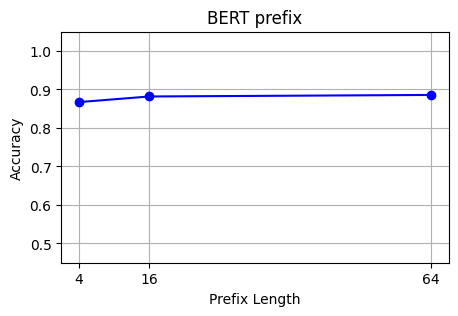

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hypothetical data
prefix_lengths = [4, 16, 64]
# Random accuracies for each prefix length (for illustration purposes)
accuracies = [0.867200,0.881800,0.885800]

# Creating the plot
plt.figure(figsize=(5, 3))
plt.plot(prefix_lengths, accuracies, marker='o', linestyle='-', color='b')
plt.title('BERT prefix')
plt.xlabel('Prefix Length')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(prefix_lengths)  # Ensure all prefix lengths are marked
plt.ylim(0.45, 1.05)  # Set y-axis limits to make the plot aesthetically better
plt.show()


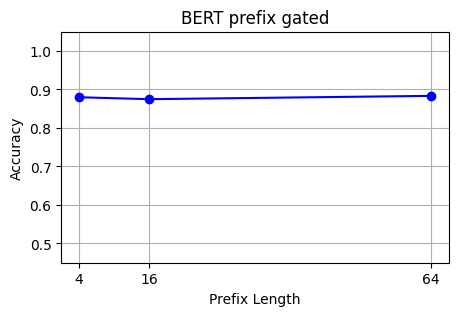

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hypothetical data
prefix_lengths = [4, 16, 64]
# Random accuracies for each prefix length (for illustration purposes)
accuracies = [0.879800, 0.874800,0.883400]

# Creating the plot
plt.figure(figsize=(5, 3))
plt.plot(prefix_lengths, accuracies, marker='o', linestyle='-', color='b')
plt.title('BERT prefix gated')
plt.xlabel('Prefix Length')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(prefix_lengths)  # Ensure all prefix lengths are marked
plt.ylim(0.45, 1.05)  # Set y-axis limits to make the plot aesthetically better
plt.show()


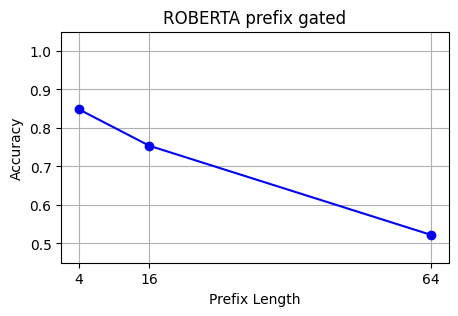

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hypothetical data
prefix_lengths = [4, 16, 64]
# Random accuracies for each prefix length (for illustration purposes)
accuracies = [0.848400, 0.753800, 0.522200]

# Creating the plot
plt.figure(figsize=(5, 3))
plt.plot(prefix_lengths, accuracies, marker='o', linestyle='-', color='b')
plt.title('ROBERTA prefix gated')
plt.xlabel('Prefix Length')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(prefix_lengths)  # Ensure all prefix lengths are marked
plt.ylim(0.45, 1.05)  # Set y-axis limits to make the plot aesthetically better
plt.show()


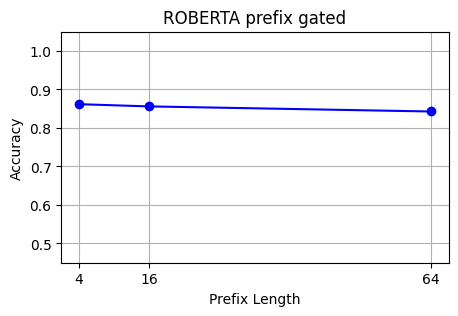

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hypothetical data
prefix_lengths = [4, 16, 64]
# Random accuracies for each prefix length (for illustration purposes)
accuracies = [0.861800,0.856000,0.842800]

# Creating the plot
plt.figure(figsize=(5, 3))
plt.plot(prefix_lengths, accuracies, marker='o', linestyle='-', color='b')
plt.title('ROBERTA prefix gated')
plt.xlabel('Prefix Length')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(prefix_lengths)  # Ensure all prefix lengths are marked
plt.ylim(0.45, 1.05)  # Set y-axis limits to make the plot aesthetically better
plt.show()


### BERT Prefix Gated 4

In [ ]:
prefix_len = 4
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = BertForSequenceClassification_Prefix_Gated.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not (name in ["bert.encoder.prefix", "bert.pooler.dense.weight", "bert.pooler.dense.bias", "classifier.weight", "classifier.bias"]) and not ("gate_mlps" in name):
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of BertForSequenceClassification_Prefix_Gated were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.gate_mlps.0.0.bias', 'bert.encoder.gate_mlps.0.0.weight', 'bert.encoder.gate_mlps.0.2.bias', 'bert.encoder.gate_mlps.0.2.weight', 'bert.encoder.gate_mlps.0.4.bias', 'bert.encoder.gate_mlps.0.4.weight', 'bert.encoder.gate_mlps.1.0.bias', 'bert.encoder.gate_mlps.1.0.weight', 'bert.encoder.gate_mlps.1.2.bias', 'bert.encoder.gate_mlps.1.2.weight', 'bert.encoder.gate_mlps.1.4.bias', 'bert.encoder.gate_mlps.1.4.weight', 'bert.encoder.gate_mlps.10.0.bias', 'bert.encoder.gate_mlps.10.0.weight', 'bert.encoder.gate_mlps.10.2.bias', 'bert.encoder.gate_mlps.10.2.weight', 'bert.encoder.gate_mlps.10.4.bias', 'bert.encoder.gate_mlps.10.4.weight', 'bert.encoder.gate_mlps.11.0.bias', 'bert.encoder.gate_mlps.11.0.weight', 'bert.encoder.gate_mlps.11.2.bias', 'bert.encoder.gate_mlps.11.2.weight', 'bert.encoder.gate_mlps.11.4.bi

Number of parameters: 5063440


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/bert_prefix_gated{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.137600,0.867491,0.797000
2,0.759700,0.595794,0.834600
3,0.564000,0.474196,0.851600
4,0.470100,0.412134,0.865000
5,0.424700,0.386030,0.871400
6,0.402100,0.369624,0.875200
7,0.383000,0.363111,0.877000
8,0.380100,0.356372,0.878400
9,0.374800,0.353793,0.878200
10,0.374300,0.352989,0.879800


TrainOutput(global_step=3130, training_loss=0.5270599438359562, metrics={'train_runtime': 613.1771, 'train_samples_per_second': 163.085, 'train_steps_per_second': 5.105, 'total_flos': 6181524537277440.0, 'train_loss': 0.5270599438359562, 'epoch': 10.0})

### BERT Prefix Gated 16

In [ ]:
prefix_len = 16
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = BertForSequenceClassification_Prefix_Gated.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not (name in ["bert.encoder.prefix", "bert.pooler.dense.weight", "bert.pooler.dense.bias", "classifier.weight", "classifier.bias"]) and not ("gate_mlps" in name):
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of BertForSequenceClassification_Prefix_Gated were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.gate_mlps.0.0.bias', 'bert.encoder.gate_mlps.0.0.weight', 'bert.encoder.gate_mlps.0.2.bias', 'bert.encoder.gate_mlps.0.2.weight', 'bert.encoder.gate_mlps.0.4.bias', 'bert.encoder.gate_mlps.0.4.weight', 'bert.encoder.gate_mlps.1.0.bias', 'bert.encoder.gate_mlps.1.0.weight', 'bert.encoder.gate_mlps.1.2.bias', 'bert.encoder.gate_mlps.1.2.weight', 'bert.encoder.gate_mlps.1.4.bias', 'bert.encoder.gate_mlps.1.4.weight', 'bert.encoder.gate_mlps.10.0.bias', 'bert.encoder.gate_mlps.10.0.weight', 'bert.encoder.gate_mlps.10.2.bias', 'bert.encoder.gate_mlps.10.2.weight', 'bert.encoder.gate_mlps.10.4.bias', 'bert.encoder.gate_mlps.10.4.weight', 'bert.encoder.gate_mlps.11.0.bias', 'bert.encoder.gate_mlps.11.0.weight', 'bert.encoder.gate_mlps.11.2.bias', 'bert.encoder.gate_mlps.11.2.weight', 'bert.encoder.gate_mlps.11.4.bi

Number of parameters: 5174032


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/bert_prefix_gated{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.204000,0.942290,0.720800
2,0.787000,0.570767,0.822200
3,0.547200,0.448772,0.855200
4,0.458100,0.401219,0.864400
5,0.425300,0.377791,0.867800
6,0.401600,0.367181,0.871200
7,0.394600,0.358861,0.871400
8,0.386000,0.353133,0.873600
9,0.379000,0.351160,0.874400
10,0.376900,0.350103,0.874800


Checkpoint destination directory ./results/sentiment/bert_prefix_gated16/checkpoint-3130 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=3130, training_loss=0.5359709913357378, metrics={'train_runtime': 677.3283, 'train_samples_per_second': 147.639, 'train_steps_per_second': 4.621, 'total_flos': 6189110327442432.0, 'train_loss': 0.5359709913357378, 'epoch': 10.0})

### BERT Prefix Gated 64

In [ ]:
prefix_len = 64
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = BertForSequenceClassification_Prefix_Gated.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not (name in ["bert.encoder.prefix", "bert.pooler.dense.weight", "bert.pooler.dense.bias", "classifier.weight", "classifier.bias"]) and not ("gate_mlps" in name):
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of BertForSequenceClassification_Prefix_Gated were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.gate_mlps.0.0.bias', 'bert.encoder.gate_mlps.0.0.weight', 'bert.encoder.gate_mlps.0.2.bias', 'bert.encoder.gate_mlps.0.2.weight', 'bert.encoder.gate_mlps.0.4.bias', 'bert.encoder.gate_mlps.0.4.weight', 'bert.encoder.gate_mlps.1.0.bias', 'bert.encoder.gate_mlps.1.0.weight', 'bert.encoder.gate_mlps.1.2.bias', 'bert.encoder.gate_mlps.1.2.weight', 'bert.encoder.gate_mlps.1.4.bias', 'bert.encoder.gate_mlps.1.4.weight', 'bert.encoder.gate_mlps.10.0.bias', 'bert.encoder.gate_mlps.10.0.weight', 'bert.encoder.gate_mlps.10.2.bias', 'bert.encoder.gate_mlps.10.2.weight', 'bert.encoder.gate_mlps.10.4.bias', 'bert.encoder.gate_mlps.10.4.weight', 'bert.encoder.gate_mlps.11.0.bias', 'bert.encoder.gate_mlps.11.0.weight', 'bert.encoder.gate_mlps.11.2.bias', 'bert.encoder.gate_mlps.11.2.weight', 'bert.encoder.gate_mlps.11.4.bi

Number of parameters: 5616400


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/bert_prefix_gated{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.975100,0.500102,0.846000
2,0.439500,0.351027,0.879733
3,0.368300,0.329381,0.887867
4,0.346900,0.317939,0.890267


Epoch,Training Loss,Validation Loss,Accuracy
1,0.975100,0.500102,0.846000
2,0.439500,0.351027,0.879733
3,0.368300,0.329381,0.887867
4,0.346900,0.317939,0.890267
5,0.333900,0.314184,0.890933
6,0.327900,0.305998,0.893867
7,0.318700,0.303543,0.893733
8,0.316900,0.307778,0.892933
9,0.311800,0.297860,0.897200
10,0.309100,0.295606,0.897200


TrainOutput(global_step=18760, training_loss=0.35199377552024336, metrics={'train_runtime': 5111.2475, 'train_samples_per_second': 117.388, 'train_steps_per_second': 3.67, 'total_flos': 3.724981775424e+16, 'train_loss': 0.35199377552024336, 'epoch': 20.0})

## ROBERTA Architecture Models

In [ ]:
model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def preprocess_function(sample):
    return tokenizer(sample["text"], truncation=True, max_length=256)

tokenized_train_ds = train_ds.map(preprocess_function, batched=True)
tokenized_test_ds = test_ds.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

### ROBERTA

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 124648708


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/roberta",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.291700,0.196129,0.934667
2,0.175200,0.208438,0.934800
3,0.129200,0.228869,0.937200
4,0.100900,0.260195,0.937200
5,0.074300,0.283108,0.939733
6,0.052300,0.390790,0.932533
7,0.039900,0.373540,0.935200
8,0.030900,0.436253,0.936000
9,0.026900,0.441322,0.936133
10,0.017600,0.477472,0.935867


Epoch,Training Loss,Validation Loss,Accuracy
1,0.291700,0.196129,0.934667
2,0.175200,0.208438,0.934800
3,0.129200,0.228869,0.937200
4,0.100900,0.260195,0.937200
5,0.074300,0.283108,0.939733
6,0.052300,0.390790,0.932533
7,0.039900,0.373540,0.935200
8,0.030900,0.436253,0.936000
9,0.026900,0.441322,0.936133
10,0.017600,0.477472,0.935867


TrainOutput(global_step=18760, training_loss=0.05030300737952373, metrics={'train_runtime': 4284.4731, 'train_samples_per_second': 140.041, 'train_steps_per_second': 4.379, 'total_flos': 3.488032161736013e+16, 'train_loss': 0.05030300737952373, 'epoch': 20.0})

### ROBERTA Prefix 4

In [ ]:
prefix_len = 4
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = RobertaForSequenceClassification_Prefix.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not name in ["roberta.encoder.prefix", "roberta.pooler.dense.weight", "roberta.pooler.dense.bias", "classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]:
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification_Prefix were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.encoder.prefix', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 1221124


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/roberta_prefix_{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.298000,1.196956,0.803867
2,1.045100,0.894748,0.844400
3,0.752700,0.626229,0.860667
4,0.569400,0.470879,0.875867
5,0.491500,0.404695,0.877600
6,0.453300,0.372254,0.880667
7,0.433200,0.356370,0.882800
8,0.423900,0.349592,0.883867
9,0.413300,0.340829,0.885600


Epoch,Training Loss,Validation Loss,Accuracy
1,1.298000,1.196956,0.803867
2,1.045100,0.894748,0.844400
3,0.752700,0.626229,0.860667
4,0.569400,0.470879,0.875867
5,0.491500,0.404695,0.877600
6,0.453300,0.372254,0.880667
7,0.433200,0.356370,0.882800
8,0.423900,0.349592,0.883867
9,0.413300,0.340829,0.885600
10,0.407800,0.334145,0.888800


TrainOutput(global_step=18760, training_loss=0.5087720891305887, metrics={'train_runtime': 3086.1689, 'train_samples_per_second': 194.416, 'train_steps_per_second': 6.079, 'total_flos': 3.5135849368859904e+16, 'train_loss': 0.5087720891305887, 'epoch': 20.0})

### ROBERTA Prefix 16

In [ ]:
prefix_len = 16
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = RobertaForSequenceClassification_Prefix.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not name in ["roberta.encoder.prefix", "roberta.pooler.dense.weight", "roberta.pooler.dense.bias", "classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]:
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of RobertaForSequenceClassification_Prefix were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.encoder.prefix', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 1331716


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/roberta_prefix_{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.382600,1.368134,0.642200
2,1.368200,1.347491,0.599800
3,1.350600,1.318653,0.655200
4,1.325900,1.279340,0.600000
5,1.296900,1.229193,0.728600
6,1.259000,1.172048,0.741800
7,1.225600,1.120480,0.758800
8,1.191400,1.079947,0.752200
9,1.177200,1.055623,0.753600
10,1.162600,1.047634,0.753800


TrainOutput(global_step=6250, training_loss=1.27399451171875, metrics={'train_runtime': 622.8597, 'train_samples_per_second': 160.55, 'train_steps_per_second': 10.034, 'total_flos': 5025119533785216.0, 'train_loss': 1.27399451171875, 'epoch': 10.0})

### ROBERTA Prefix 64

In [ ]:
prefix_len = 64
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = RobertaForSequenceClassification_Prefix.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not name in ["roberta.encoder.prefix", "roberta.pooler.dense.weight", "roberta.pooler.dense.bias", "classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]:
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of RobertaForSequenceClassification_Prefix were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.encoder.prefix', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 1774084


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/roberta_prefix_{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.385200,1.375876,0.379200
2,1.379000,1.365471,0.467000
3,1.371500,1.353895,0.432400
4,1.366600,1.346171,0.286000
5,1.359000,1.328869,0.471400
6,1.352000,1.315184,0.598400
7,1.342600,1.303096,0.604400
8,1.339500,1.296727,0.507200
9,1.334600,1.290639,0.556400
10,1.332600,1.289778,0.522200


TrainOutput(global_step=6250, training_loss=1.35627912109375, metrics={'train_runtime': 894.5829, 'train_samples_per_second': 111.784, 'train_steps_per_second': 6.986, 'total_flos': 5050851804307584.0, 'train_loss': 1.35627912109375, 'epoch': 10.0})

### ROBERTA Prefix Gated 4

In [ ]:
prefix_len = 4
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = RobertaForSequenceClassification_Prefix_Gated.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not (name in ["roberta.encoder.prefix", "roberta.pooler.dense.weight", "roberta.pooler.dense.bias", "classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]) and not ("gate_mlps" in name):
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of RobertaForSequenceClassification_Prefix_Gated were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.encoder.gate_mlps.0.0.bias', 'roberta.encoder.gate_mlps.0.0.weight', 'roberta.encoder.gate_mlps.0.2.bias', 'roberta.encoder.gate_mlps.0.2.weight', 'roberta.encoder.gate_mlps.0.4.bias', 'roberta.encoder.gate_mlps.0.4.weight', 'roberta.encoder.gate_mlps.1.0.bias', 'roberta.encoder.gate_mlps.1.0.weight', 'roberta.encoder.gate_mlps.1.2.bias', 'roberta.encoder.gate_mlps.1.2.weight', 'roberta.encoder.gate_mlps.1.4.bias', 'roberta.encoder.gate_mlps.1.4.weight', 'roberta.encoder.gate_mlps.10.0.bias', 'roberta.encoder.gate_mlps.10.0.weight', 'roberta.encoder.gate_mlps.10.2.bias', 'roberta.encoder.gate_mlps.10.2.weight', 'roberta.encoder.gate_mlps.10.4.bias', 'roberta.encoder.gate_mlps.10.4.weight', 'roberta.encoder.g

Number of parameters: 5654032


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/roberta_prefix_gated_{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.280800,1.128652,0.840133
2,0.948600,0.734473,0.855867
3,0.644700,0.502417,0.868267
4,0.504500,0.410451,0.876000
5,0.441800,0.369111,0.880533
6,0.415800,0.350024,0.883600
7,0.402400,0.337318,0.887333
8,0.392800,0.330052,0.887333
9,0.385500,0.324058,0.888667
10,0.382000,0.321365,0.889200


TrainOutput(global_step=18760, training_loss=0.47288358155598265, metrics={'train_runtime': 3215.0738, 'train_samples_per_second': 186.621, 'train_steps_per_second': 5.835, 'total_flos': 3.694112497997107e+16, 'train_loss': 0.47288358155598265, 'epoch': 20.0})

### ROBERTA Prefix Gated 16

In [ ]:
prefix_len = 16
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = RobertaForSequenceClassification_Prefix_Gated.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not (name in ["roberta.encoder.prefix", "roberta.pooler.dense.weight", "roberta.pooler.dense.bias", "classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]) and not ("gate_mlps" in name):
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of RobertaForSequenceClassification_Prefix_Gated were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.encoder.gate_mlps.0.0.bias', 'roberta.encoder.gate_mlps.0.0.weight', 'roberta.encoder.gate_mlps.0.2.bias', 'roberta.encoder.gate_mlps.0.2.weight', 'roberta.encoder.gate_mlps.0.4.bias', 'roberta.encoder.gate_mlps.0.4.weight', 'roberta.encoder.gate_mlps.1.0.bias', 'roberta.encoder.gate_mlps.1.0.weight', 'roberta.encoder.gate_mlps.1.2.bias', 'roberta.encoder.gate_mlps.1.2.weight', 'roberta.encoder.gate_mlps.1.4.bias', 'roberta.encoder.gate_mlps.1.4.weight', 'roberta.encoder.gate_mlps.10.0.bias', 'roberta.encoder.gate_mlps.10.0.weight', 'roberta.encoder.gate_mlps.10.2.bias', 'roberta.encoder.gate_mlps.10.2.weight', 'roberta.encoder.gate_mlps.10.4.bias', 'roberta.encoder.gate_mlps.10.4.weight', 'roberta.encoder.g

Number of parameters: 5764624


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/roberta_prefix_gated_{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.362500,1.325003,0.780800
2,1.284100,1.201925,0.790600
3,1.150200,1.002728,0.825600
4,0.966600,0.755729,0.843000
5,0.809700,0.600615,0.845400
6,0.701700,0.518454,0.850400
7,0.645600,0.478939,0.852200
8,0.614700,0.458168,0.855400
9,0.601400,0.449634,0.854800
10,0.596600,0.446780,0.856000


TrainOutput(global_step=6250, training_loss=0.873317099609375, metrics={'train_runtime': 673.1805, 'train_samples_per_second': 148.549, 'train_steps_per_second': 9.284, 'total_flos': 5282979026010624.0, 'train_loss': 0.873317099609375, 'epoch': 10.0})

### ROBERTA Prefix Gated 64

In [ ]:
prefix_len = 64
num_labels = 4

In [ ]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_labels
config.prefix_len = prefix_len

In [ ]:
model = RobertaForSequenceClassification_Prefix_Gated.from_pretrained(model_name, config=config)
for name, param in model.named_parameters():
    if not (name in ["roberta.encoder.prefix", "roberta.pooler.dense.weight", "roberta.pooler.dense.bias", "classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]) and not ("gate_mlps" in name):
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Some weights of RobertaForSequenceClassification_Prefix_Gated were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.encoder.gate_mlps.0.0.bias', 'roberta.encoder.gate_mlps.0.0.weight', 'roberta.encoder.gate_mlps.0.2.bias', 'roberta.encoder.gate_mlps.0.2.weight', 'roberta.encoder.gate_mlps.0.4.bias', 'roberta.encoder.gate_mlps.0.4.weight', 'roberta.encoder.gate_mlps.1.0.bias', 'roberta.encoder.gate_mlps.1.0.weight', 'roberta.encoder.gate_mlps.1.2.bias', 'roberta.encoder.gate_mlps.1.2.weight', 'roberta.encoder.gate_mlps.1.4.bias', 'roberta.encoder.gate_mlps.1.4.weight', 'roberta.encoder.gate_mlps.10.0.bias', 'roberta.encoder.gate_mlps.10.0.weight', 'roberta.encoder.gate_mlps.10.2.bias', 'roberta.encoder.gate_mlps.10.2.weight', 'roberta.encoder.gate_mlps.10.4.bias', 'roberta.encoder.gate_mlps.10.4.weight', 'roberta.encoder.g

Number of parameters: 6206992


In [ ]:
training_args = TrainingArguments(
    output_dir=f"./results/sentiment/roberta_prefix_gated_{prefix_len}",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    # use_mps_device=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.378600,1.355323,0.661000
2,1.320200,1.226300,0.788800
3,1.144600,0.950742,0.815000
4,0.922300,0.703653,0.821200
5,0.774100,0.579139,0.829600
6,0.698300,0.526479,0.834200
7,0.660800,0.498424,0.835200
8,0.642300,0.484710,0.839800
9,0.625500,0.476651,0.842600
10,0.624700,0.474349,0.842800


TrainOutput(global_step=6250, training_loss=0.8791316552734375, metrics={'train_runtime': 938.5192, 'train_samples_per_second': 106.551, 'train_steps_per_second': 6.659, 'total_flos': 5308711296532992.0, 'train_loss': 0.8791316552734375, 'epoch': 10.0})